# Семинар 2: пуассоновский процесс

Данный процесс встречается в реальной жизни довольно часто;
он описывает поток случайных событий, которые регистрируются с некоторой постоянной "интенсивностью".
Например, речь может идти о регистрации космических частиц, о кликах по ссылке,
о запросах к серверу, о проезжающих по магистрали автомобилях.

Пуассоновский процесс можно неформально определить следующим образом:
пусть ось времени разбита на бесконечно малые промежутки $ \Delta t $.
Тогда пуассоновский процесс ведёт себя следующим образом:
в самом начале он равен нулю,
и на каждом последующем шаге по времени может претерпеть скачок на $ + 1 $ с вероятностью $ \lambda \Delta t $.
Параметр $ \lambda $ называется интенсивностью процесса и характеризует "скорость" потока событий.

Промоделируем этот процесс при помощи приведённого "наивного" определения.

In [1]:
import numpy as np
import pandas as pd

# Фиксируем зерно для генертора случайных чисел.
np.random.seed(seed=42)

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
# Раскомментировать, если следующая ячейка не работает.
#import sys
#sys.path.insert(1, ".")

In [4]:
from utils.plots import plot_realizations, plot_slices, plot_correlation_function

In [5]:
# Интенсивность процесса.
lamb = 2.0

In [6]:
from scipy.stats import bernoulli

In [7]:
def generate_poisson_sp_naive(T, lamb=1.0, realizations_number=25):
    """
    Сгенерировать realizations_number реализаций пуассоновского процесса наивным методом.
    """
    
    T = np.sort(T)
    realizations = np.zeros((realizations_number, T.shape[0]))
    
    # Для каждого очередного момента времени производится независимая генерация произошедших
    # на пройденном интервале скачков согласно бернуллиевскому распределению с параметром p = \lambda * \Delta t.
    for index in range(T.shape[0] - 1):
        realizations[:,index + 1] = realizations[:,index] + bernoulli(p=lamb*(T[index+1] - T[index])).rvs((realizations_number))
        # Важно понимать, что "наивная" реализация может легко сломаться: p = \lambda * \Delta t может оказаться больше 1, что не имеет смысла.
    
    return realizations

In [8]:
T_naive = np.linspace(0.0, 10.0, 200)
poisson_sp_naive = generate_poisson_sp_naive(T_naive, lamb=lamb, realizations_number=10)

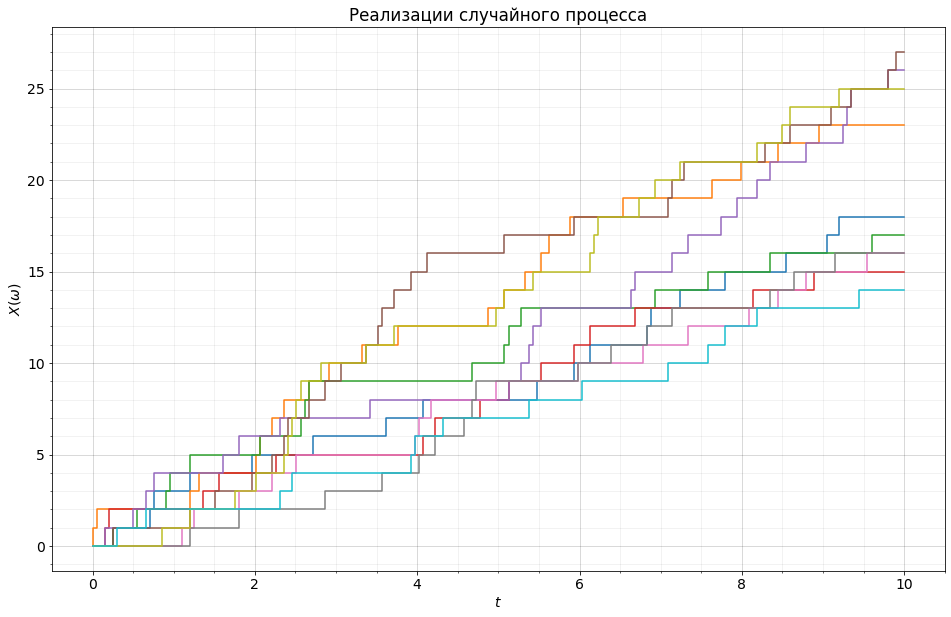

In [9]:
plot_realizations(T_naive, poisson_sp_naive, is_discrete=True)

Дадим теперь формальное определение.

**Пуассоновским процессом с интенсивностью $ \lambda > 0 $** называется случайный процесс $ K \colon \Omega \times [0; +\infty) \to \mathbb{N} $ такой, что
1. $ K_0 \underset{\text{п.н.}}{=} 0 $.
2. $ K $ - процесс с независимыми приращениями.
3. $ K_t - K_s \sim \text{Po}(\lambda \cdot (t - s)) $.

Это одно из эквивалентных определений.
Промоделируем его.

In [10]:
from scipy.stats import poisson

In [11]:
def generate_poisson_sp_1(T, lamb=1.0, realizations_number=25):
    """
    Сгенерировать realizations_number реализаций пуассоновского процесса первым методом.
    """
    
    T = np.sort(T)
    realizations = np.zeros((realizations_number, T.shape[0]))
    
    # Для каждого очередного момента времени производится независимая генерация произошедших
    # на пройденном интервале скачков согласно распределению Пуассона.
    for index in range(T.shape[0] - 1):
        realizations[:,index + 1] = realizations[:,index] + poisson(mu=lamb*(T[index+1] - T[index])).rvs((realizations_number))
    
    return realizations

In [12]:
T_1 = np.linspace(0.0, 10.0, 200)
poisson_sp_1 = generate_poisson_sp_1(T_1, lamb=lamb, realizations_number=10)

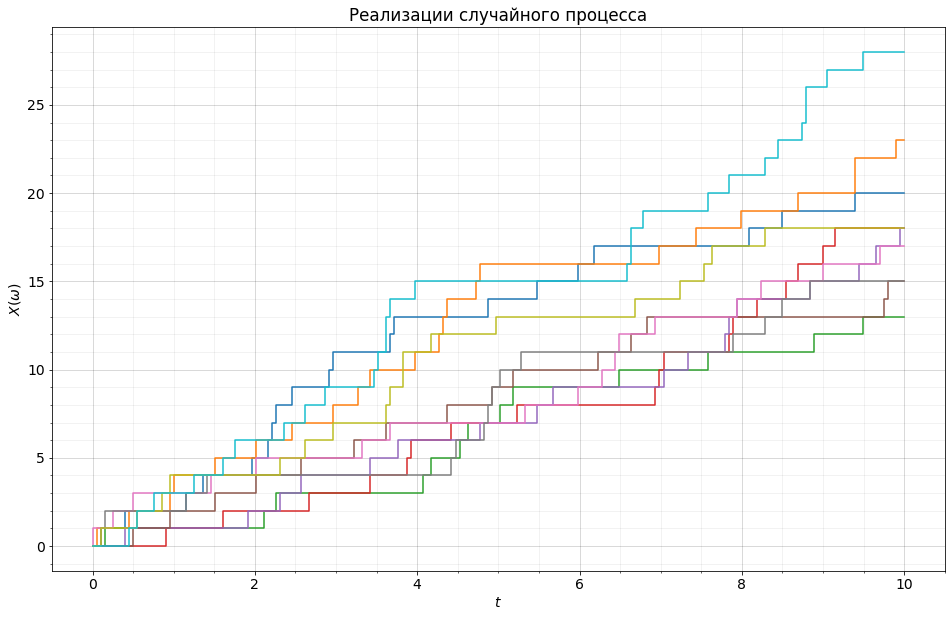

In [13]:
plot_realizations(T_1, poisson_sp_1, is_discrete=True)

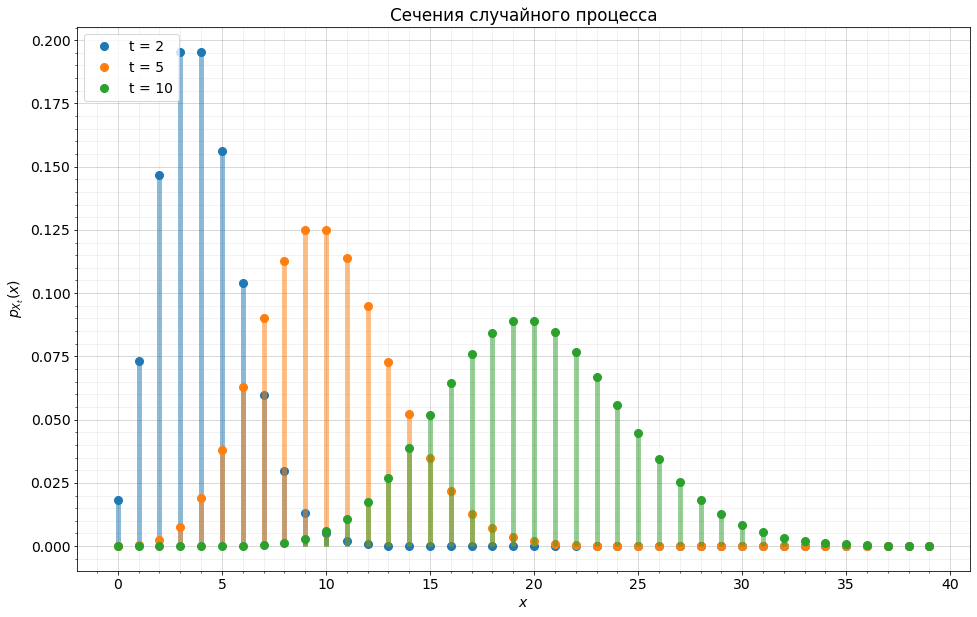

In [14]:
plot_slices(np.arange(0, 20 * int(np.ceil(lamb))), [(poisson(mu=lamb*t), f"t = {t}") for t in [2, 5, 10]], is_discrete=True)

In [15]:
# Для конспекта семинаров.
#dataframe = pd.DataFrame(data=poisson_sp_1.T, columns=[f"realization_{index}" for index in range(poisson_sp_1.shape[0])])
#dataframe.insert(0, "time", T_1)
#dataframe.to_csv("../data/Poisson_realizations.csv", index=False)

Приведём альтернативное определение пуассоновского процесса, облегчающее его моделирование:
Пусть $ \xi_1, \ldots, \xi_k, \ldots \sim \text{Exp}(\lambda) $ и независимы в совокупности,
$ \tau_n = \xi_1 + \ldots + \xi_n $.
Тогда процесс $ X_t = \sup\{n \mid \tau_n \leqslant t\} $ есть пуассоновский процесс с интенсивностью $ \lambda $.

Процесс $ X_t $, построенный по случайным величинам $ \xi_k $ способом, указанным выше,
называется **процессом восстановления, построенным по величинам $ \{ \xi_k \}_{k \in \mathbb{N}} $**, и отвечает следующей модели:
в нулевой момент включается прибор, который работает время $ \xi_1 $, после чего ломается.
Одновременно с поломкой включается следующий прибор, который работает случайное время $ \xi_2 $, и так далее.
Величина $ X_t $ отражает количество приборов, введённых в эксплуатацию к моменту $ t $.

In [16]:
from scipy.stats import expon

In [17]:
def generate_poisson_sp_2(T, lamb=1.0, realizations_number=25):
    """
    Сгенерировать realizations_number реализаций пуассоновского процесса первым методом.
    """
    
    T = np.sort(T)
    realizations = np.zeros((realizations_number, T.shape[0]))
    
    # Первый цикл - по реализациям.
    for realization_index in range(realizations_number):
        time_index = 0   # Индекс текущего момента времени
        counter = 0      # Счётчик событий.
        current_t = T[0] # Текущее время.
        
        # Второй цикл - по времени внутри реализации (до конца промежутка моделирования).
        while current_t < T[-1]:
            next_t = current_t + expon(scale=1.0/lamb).rvs(1) # Момент времени, в который произошло следующее событие.
            while time_index < T.shape[0] and T[time_index] < next_t:
                # В интервале между скачками ничего не происходит, counter не меняется.
                realizations[realization_index][time_index] = counter
                time_index += 1

            # Прохождение скачка.
            current_t = next_t
            counter += 1
    
    return realizations

In [18]:
T_2 = np.linspace(0.0, 10.0, 200)
poisson_sp_2 = generate_poisson_sp_2(T_1, lamb=lamb, realizations_number=10)

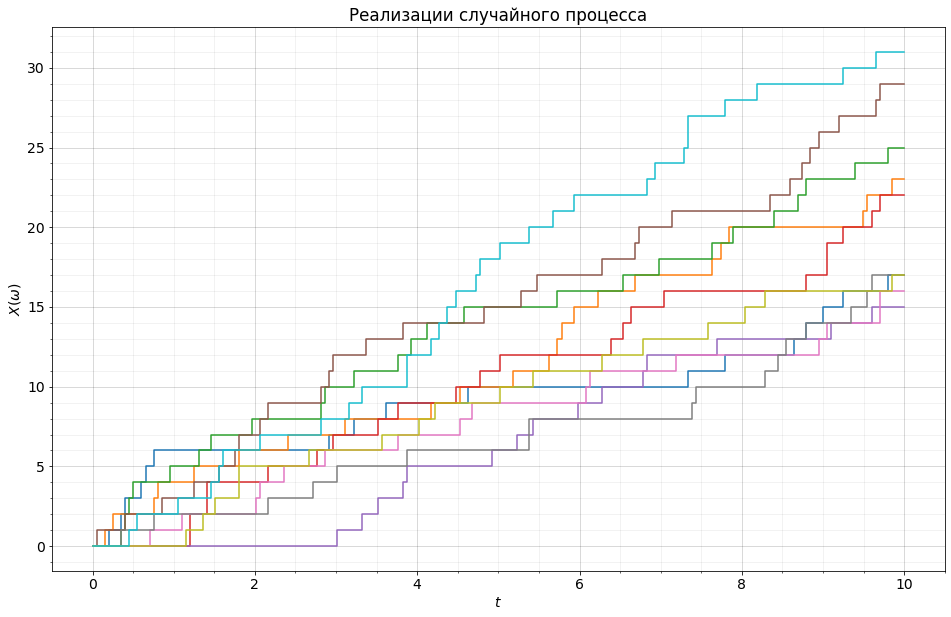

In [19]:
plot_realizations(T_2, poisson_sp_2, is_discrete=True)